## Preprocess Dataset

#### Clean Mnist data

In [ ]:
import cv2
import os

def process_image(input_image_path, output_image_path):
    img = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    img_blur = cv2.GaussianBlur(img, (1, 1), 0)
    binary_image = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11,-28)
    cv2.imwrite(output_image_path, binary_image)

input_dataset_path = r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\3_Mnist\Filtered"
output_dataset_path = r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\MNIST_NOISEREDUCTION"

for digit_folder in os.listdir(input_dataset_path):
    digit_folder_path = os.path.join(input_dataset_path, digit_folder)
    if os.path.isdir(digit_folder_path):
        output_digit_folder_path = os.path.join(output_dataset_path, digit_folder)
        os.makedirs(output_digit_folder_path, exist_ok=True)
        
        for filename in os.listdir(digit_folder_path):
            if filename.endswith(".jpg"):
                input_image_path = os.path.join(digit_folder_path, filename)
                output_image_path = os.path.join(output_digit_folder_path, filename.split('.')[0] + ".png")
                process_image(input_image_path, output_image_path)


#### Set LSB 1 

1


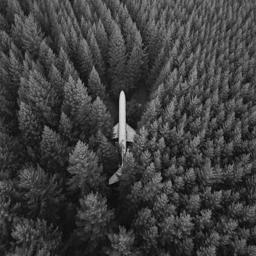

In [8]:
from PIL import Image

def set_lsb(pixel_value, lsb_bit):
    cleared_pixel_value = pixel_value & 0b1111111111111110
    # Set the LSB to the desired value 
    modified_pixel_value = cleared_pixel_value | lsb_bit
    return modified_pixel_value

def manipulate_image_lsb(input_image_path, output_image_path, lsb_value=0):
    print(lsb_value)
    original_image = Image.open(input_image_path)
    image_data = list(original_image.getdata())
    manipulated_data = [set_lsb(pixel_value, lsb_value) for pixel_value in image_data]
    manipulated_image = Image.new(original_image.mode, original_image.size)
    manipulated_image.putdata(manipulated_data)
    manipulated_image.save(output_image_path)

    return manipulated_image
manipulate_image_lsb(r'D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\xd\L_image3.png', 'L_image3.png', lsb_value=1) 

#### Split dataset into Stego and Non-Stego folders (80:20 ratio) 

In [ ]:
import os
import shutil
import random

def copy_random_files(source_dir, destination_dir1, destination_dir2, percentage=50):
    if not os.path.exists(source_dir):
        print(f"Source directory '{source_dir}' does not exist.")
        return
    if not os.path.exists(destination_dir1):
        os.makedirs(destination_dir1)
    if not os.path.exists(destination_dir2):
        os.makedirs(destination_dir2)
    files = os.listdir(source_dir)
    image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print("No image files found in the source directory.")
        return
    num_files_to_copy1 = int(len(image_files) * percentage / 100)
    num_files_to_copy2 = len(image_files) - num_files_to_copy1
    files_to_copy = random.sample(image_files, len(image_files))
    for i, file in enumerate(files_to_copy):
        source_file_path = os.path.join(source_dir, file)
        
        if i < num_files_to_copy1:
            destination_file_path = os.path.join(destination_dir1, file)
        else:
            destination_file_path = os.path.join(destination_dir2, file)
        
        shutil.copy(source_file_path, destination_file_path)
        print(f"Copied '{source_file_path}' to '{destination_file_path}'")
    
    print("Copying completed.")

source_directory = r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\New folder IMP\archive\boss_256_0.4_test\cover"
destination_directory1 = r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\New folder IMP\DATASET5\TEST_DATASET5\TEST"
destination_directory2 = r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\New folder IMP\DATASET5\TEST_DATASET5\TEST_NONSTEGO"
copy_random_files(source_directory, destination_directory1, destination_directory2, percentage=80)



#### Hide Mnist data into Stego folder images

In [14]:
import os
import random
import numpy as np
from PIL import Image

def load_mnist_images(mnist_folder_path):
    mnist_images = []
    for digit in range(10):
        if digit % 2 == 0:
            digit_folder = os.path.join(mnist_folder_path, str(digit))
            image_files = os.listdir(digit_folder)
            random_image_file = random.choice(image_files)
            image_path = os.path.join(digit_folder, random_image_file)
            image = Image.open(image_path).convert("L") 
            mnist_images.append(np.array(image))
    return mnist_images

def embed_mnist_images(cover_image_path, mnist_images):
    cover_image = Image.open(cover_image_path)
    cover_array = np.array(cover_image)
    image_size = mnist_images[0].shape[0] 
    cover_size = cover_array.shape[0]
    assert len(mnist_images) <= (cover_size // image_size) ** 2, "Cover image is too small"

    positions = set()
    occupied_regions = set()
    
    while len(positions) < len(mnist_images):
        x = np.random.randint(0, cover_size - image_size)
        y = np.random.randint(0, cover_size - image_size)
        overlapping = False
        for region in occupied_regions:
            region_x, region_y, region_size = region
            if (x >= region_x and x < region_x + region_size) and \
               (y >= region_y and y < region_y + region_size):
                overlapping = True
                break
    
        if not overlapping:
            positions.add((x, y))
            occupied_regions.add((x, y, image_size))
    
    for i, (x, y) in enumerate(positions):
        mnist_image = mnist_images[i]
        for row in range(image_size):
            for col in range(image_size):
                cover_array[y + row, x + col] &= 0b1111111111111110  
                cover_array[y + row, x + col] |= (mnist_image[row, col] & 1) 

    steganographic_image = Image.fromarray(cover_array)
    return steganographic_image

cover_image_path = r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\k"
mnist_folder_path = r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\NEWDATASET2\MNIST_NOISEREDUCTION"
DestinationFolder = r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\n"

for filename in os.listdir(cover_image_path):
    if filename.endswith(".png"): 
        image_path = os.path.join(cover_image_path, filename)
        mnist_images = load_mnist_images(mnist_folder_path)
        steganographic_image = embed_mnist_images(image_path, mnist_images)
        destination_path = os.path.join(DestinationFolder, filename)
        steganographic_image.save(destination_path)

#### LSB Decoder 

In [15]:
def LSB_decoder(steganographic_image_path, output_image_path):
    steganographic_image = Image.open(steganographic_image_path)
    steganographic_array = np.array(steganographic_image)
    extracted_rectangle = steganographic_array & 1
    # extracted_image = Image.fromarray((extracted_rectangle * 255).astype(np.uint8))
    extracted_image = Image.fromarray((extracted_rectangle*255).astype(np.uint8))
    extracted_image.save(output_image_path)

    
LSB_decoder(r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\n\L_image1.png", "Decoded_image1.png")

#### Image processing (Resize and gray scale) ----------------------------------------------------------------

In [7]:
from PIL import Image
import os

def resize_and_convert_to_grayscale(image_path, output_path):
    img = Image.open(image_path)
    img_gray = img.convert('L')
    img_resized = img_gray.resize((256, 256))
    img_resized.save(output_path)
    print("Image saved successfully at", output_path)

input_image_path = r"D:\IEM\SEM3\Project\CREATE_LSB_Stego_dataset\xd\photo-1507608616759-54f48f0af0ee.jpg"
output_image_path = "image2.jpg"
resize_and_convert_to_grayscale(input_image_path, output_image_path)


Image saved successfully at image2.jpg


## Model for steganographic image detection

##### Import required packages

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Resize, Grayscale, Compose

#### Preprocessing data/ dataloders

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_path = "/kaggle/input/dataset/Dataset5_final/DATASET5"
test_data_path = "/kaggle/input/dataset/Dataset5_final/TEST_DATASET5"

# Preprocess
transform = ToTensor()
resize = Resize((128, 128))  
grayscale = Grayscale()
transform_pipeline = Compose([resize, grayscale, transform])

train_data = ImageFolder(data_path, transform=transform_pipeline)
test_data = ImageFolder(test_data_path, transform=transform_pipeline)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False) 

#### CNN Model

In [ ]:

class SteganographyDetector(nn.Module):
    def __init__(self):
        super(SteganographyDetector, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Calculate the expected output size after conv3
        input_size = 128  # Reduced input image size
        self.output_size = input_size
        self.output_size = (self.output_size + 2 * 2 - 5) // 1 + 1  # conv1
        self.output_size = (self.output_size - 2) // 2 + 1  # maxpool
        self.output_size = (self.output_size + 2 * 1 - 3) // 1 + 1  # conv2
        self.output_size = (self.output_size - 2) // 2 + 1  # maxpool
        self.output_size = (self.output_size + 2 * 1 - 3) // 1 + 1  # conv3

        self.fc1 = nn.Linear(128 * self.output_size * self.output_size, 512)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.drop2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, 128 * self.output_size * self.output_size)
        x = F.relu(self.drop1(self.fc1(x)))
        x = F.relu(self.drop2(self.fc2(x)))
        x = self.fc3(x)
        return x

model = SteganographyDetector().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Model Training 

In [ ]:
epochs = 20
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    model_path = '/kaggle/working/LSB_Steganolysis_v5.pth'
    torch.save(model.state_dict(), model_path)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)} Model Updateed')


model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')
x = 100 * correct / total
model_path = '/kaggle/working/LSB_Steganolysis_v5_' + str(x) + '.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

#### Load saved model and test on folders

In [ ]:
from torchvision.transforms.functional import to_tensor, resize, to_pil_image, adjust_brightness, adjust_contrast
from torchvision.transforms import Grayscale
from PIL import Image

model = SteganographyDetector().to(device)
saved_model_path = '/kaggle/input/model-v5/LSB_Steganolysis_v5.pth'
model.load_state_dict(torch.load(saved_model_path))
model.eval()

def predict_steganography_probability(image_path):
    image = Image.open(image_path).convert('RGB')
    image = Grayscale()(image)           
    image = resize(image, (128, 128))    
    image = to_tensor(image)             
    image = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = F.softmax(model(image), dim=1)
    
    stego_probability = output[0][1].item() * 100 
    return stego_probability

def classify_images_in_folder(folder_path,Threshold):
    steganographic_count = 0
    non_steganographic_count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            image_path = os.path.join(folder_path, filename)
            stego_probability = predict_steganography_probability(image_path)
            if stego_probability > Threshold :  
                steganographic_count += 1
            else:
                non_steganographic_count += 1
    return non_steganographic_count, steganographic_count

    

Threshold = 60

NonStegofolder_path = r"/kaggle/input/dataset/Dataset5_final/TEST_DATASET5/TEST_NONSTEGO" 
non_steganographic, steganographic = classify_images_in_folder(NonStegofolder_path,Threshold)
print("NONSTEGO: Number of non-steganographic images:", non_steganographic)
print("NONSTEGO: Number of steganographic images:", steganographic)
nonstego_percentage = (non_steganographic / 200 )* 100 
print("NONSTEGO: percentage:", nonstego_percentage )

Stegofolder_path = r"/kaggle/input/dataset/Dataset5_final/TEST_DATASET5/TEST_STEGO" 
non_steganographic, steganographic = classify_images_in_folder(Stegofolder_path,Threshold)
print("Number of non-steganographic images:", non_steganographic)
print("Number of steganographic images:", steganographic)
stego_percentage = (steganographic / 800 )* 100
print("Stego percentage:",stego_percentage )